# step0: dependencies

In [1]:
import numpy as np
import os
from random import shuffle
import re
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import collections
import time

%matplotlib inline

In [2]:
import urllib.request
import zipfile
import lxml.etree

# step1: load data
output:  
**input_texts**: list of 2085 talk transcriptions (entire text, not tokenized, mixed case, punctuation etc.)  
**labels**: corresponding list of 2085 strings containing several keywords each  

In [3]:
# Download the dataset if it's not already there
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [4]:
# extract both the texts and the labels from the xml file
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = doc.xpath('//content/text()')
labels = doc.xpath('//head/keywords/text()')
del doc
#print(input_texts[0])
#print(labels[0])

# step2: preprocessing inputs and labels and building embeddings
output:  
**inputs_train**: list of 1585 tuples of (token_list, label_integer) for training  
**inputs_test**: list of 250 tuples of (token_list, label_integer) for testing  
**inputs_cv**: list of 250 tuples of (token_list, label_integer) for cv

In [5]:
# preprocess the texts: lowercase, remove text in parentheses, remove punctuation, tokenize into words (split on whitespace)
#removing text in parentheses
input_texts = [re.sub(r'\([^)]*\)', '', input_text) for input_text in texts]
#lowercase
input_texts = [input_text.lower() for input_text in input_texts]
#remove punctuation
input_texts = [re.sub(r'[^a-z0-9]+', ' ', input_text) for input_text in input_texts]
#tokenize into words
input_texts = [input_text.split() for input_text in input_texts]
len(input_texts)
#input_texts[0][:50]

2085

[    0.    671.5  1343.   2014.5  2686.   3357.5  4029.   4700.5  5372.
  6043.5  6715. ]


<Container object of 10 artists>

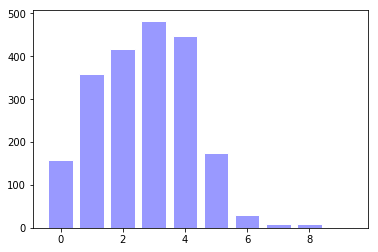

In [6]:
#histogram over input lengths
Y_plot, X_plot = np.histogram([len(text) for text in input_texts], bins=10)
print(X_plot)
X_plot = np.arange(10)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')

In [7]:
#get list of all words, and feed them into a Counter
all_words = [word for input_text in input_texts for word in input_text]
print("There are {} tokens in the dataset.".format(len(all_words)))
all_words_counter = collections.Counter(all_words)

#remove some noise, take away the 100 most common and all words that only appear once
most_common_50 = [word for word, count in all_words_counter.most_common(100)]
only_once = [word for word, count in all_words_counter.most_common() if count == 1]
print("There are {} tokens that appear only once.".format(len(only_once)))

to_remove = set(only_once + most_common_50)
print("There are {} unique tokens to remove.".format(len(to_remove)))

start = time.time()
input_texts = [[word for word in input_text if word not in to_remove] for input_text in input_texts]
print("It took {} seconds to remove all unnecessary items.".format(time.time()-start))

new_all_words = [word for input_text in input_texts for word in input_text]
print("There are now only {} tokens in the dataset.".format(len(new_all_words)))

#input_texts[0]

There are 4474850 tokens in the dataset.
There are 18438 tokens that appear only once.
There are 18538 unique tokens to remove.
It took 0.5074748992919922 seconds to remove all unnecessary items.
There are now only 1926086 tokens in the dataset.


In [8]:
#remove all inputs that have less than 500 tokens in them
inputs = zip(input_texts, labels)
inputs = [text_and_labels for text_and_labels in inputs if len(text_and_labels[0]) > 300]
print("There are now only {} inputs left.".format(len(inputs)))
input_texts, labels = zip(*inputs)
input_texts, labels = list(input_texts), list(labels)

There are now only 1924 inputs left.


In [9]:
#padding every text to the max text length for later batching
#l_max = max([len(text) for text in input_texts])
#for text in input_texts:
#    text += ['<zero_pad>'] * (l_max - len(text))

#truncating every text to only the first 500 tokens
l_max = 1000
input_texts = [text[:l_max] for text in input_texts]
input_texts = [(['<zero_pad>'] * (l_max - len(text)) + text) for text in input_texts]

#print(input_texts[0][-10:-1])
#print(np.mean([len(text) for text in input_texts]) == l_max)

In [10]:
# preprocess the labels: search for occurences of the keywords "technology", "entertainment" or "design" and build labels
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i in range(len(labels)):
    ted_labels = ['o', 'o', 'o']
    keyword_list = labels[i].split(', ')
    if 'technology' in keyword_list:
        ted_labels[0] = 'T'
    if 'entertainment' in keyword_list:
        ted_labels[1] = 'E'
    if 'design' in keyword_list:
        ted_labels[2] = 'D'
    labels[i] = ''.join(ted_labels)
    labels[i] = label_lookup.index(labels[i])
len(labels)
labels[:20]

[0, 0, 0, 3, 5, 0, 0, 0, 0, 5, 0, 3, 2, 5, 0, 0, 3, 0, 5, 0]

In [11]:
# creating the unique vocabulary lookup
vocab_list = list(set([word for input_text in input_texts for word in input_text]))
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab_list):
    word_to_index[word] = i
    index_to_word[i] = word
input_indices_list = []
for input_text in input_texts:
    input_indices_list.append([word_to_index[word] for word in input_text])
len(vocab_list)
#del vocab_list
#del input_texts

35562

In [12]:
#load glove word vectors
glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)

In [13]:
#creating embeddings, checking for each word in the input texts whether it is part of 
#the glove corpus, if yes intialize that row in the embeddings with the glove value, if
#not initialize it uniformly between [-.1, .1]
voc_len = len(word_to_index)
print("vocabulary size: {} words".format(voc_len))
counter = 0
not_found_list = []
embeddings = np.random.uniform(-.1, .1, size=(voc_len, 50))
for word, index in word_to_index.items():
    if word in glove.vocab:
        counter += 1
        embeddings[index] = glove[word]
    elif word == '<zero_pad>':
        embeddings[index] = np.zeros(50)
    else:
        not_found_list.append(word)
print("found {} word vectors, {} of our vocabulary".format(counter, float(counter)/voc_len))
print("missing words e.g. {}".format(not_found_list[0:50]))
        

vocabulary size: 35562 words
found 34558 word vectors, 0.9717676171193971 of our vocabulary
missing words e.g. ['sneakerheads', 'sammich', 'sanghamitra', 'sristi', 'delish', 'parabiosis', 'whitopians', 'daasanach', 'lmao', 'microbloggers', 'tulles', 'tananger', 'synecdochically', 'diastrophic', 'fortingall', 'manhouse', 'rcif', 'umvelt', 'thylacines', 'unpicking', 'bollacker', 'guaym', 'eetwidomayloh', 'blackawton', 'manspace', 'transfigure', 'angrigami', 'emeruwa', 'hololens', 'otherizing', 'mengatoue', 'cloudbook', 'nkali', 'sitopia', 'compassionating', 'genspace', 'spatialized', 'protonmail', 'computerish', 'zoobiquity', 'brck', 'pffff', 'commodifies', 'malem', 'diybio', 'flagelliform', 'schr', 'resorbing', 'permissionless', 'okollet']


In [14]:
# combining the tokens and labels for each input, then shuffle them and split into train/test/cv
#inputs_combined = list(zip(input_indices_list, labels))
#shuffle(inputs_combined)
#inputs_train = inputs_combined[:1450]
#inputs_test = inputs_combined[1450:1550]
#inputs_cv = inputs_combined[1550:]
#print((len(inputs_train), len(inputs_test), len(inputs_cv)))
#print(inputs_train[0])
#print([index_to_word[i] for i in inputs_train[0][0]])
#print([input_pair[1] for input_pair in inputs_train])

#keep the class label distribution intact
inputs_combined = list(zip(input_indices_list, labels))
inputs_train, inputs_test, inputs_cv = [], [], []
for n in range(len(label_lookup)):
    inputs_of_curr_class = [inpu for inpu in inputs_combined if inpu[1] == n]
    l = len(inputs_of_curr_class)
    split1 = round(0.8*l)
    split2 = round(0.9*l)
    inputs_train.extend(inputs_of_curr_class[:split1])
    inputs_cv.extend(inputs_of_curr_class[split1:split2])
    inputs_test.extend(inputs_of_curr_class[split2:])

shuffle(inputs_train)
shuffle(inputs_cv)
shuffle(inputs_test)
print((len(inputs_train), len(inputs_test), len(inputs_cv)))
    

(1540, 192, 192)


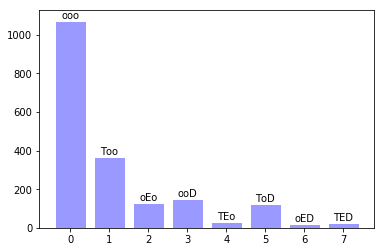

In [15]:
#plotting a histogram over the label distribution in the entire dataset
#as you can see 'ooo' is basically ~50% of the dataset, so an accuracy score
#of 50% could be reached by simply learning to predict 'ooo' all the time (not good)
Y_plot = np.histogram(labels, bins=8)[0]
X_plot = np.arange(8)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')
for x,y in zip(X_plot,Y_plot):
    plt.text(x, y+0.05, label_lookup[x], ha='center', va= 'bottom')

# step3: building the tensorflow model

In [16]:
# building the tensorflow logistic regression model
import tensorflow as tf


In [17]:
class TextClassifier(object):
    def __init__(self, lr, activation, train_algo, embeddings, train_embeddings, voc_len, embed_size, batch_size, hidden_units, classes):
        #placeholders
        #(batch_size left)
        self.input_ph = tf.placeholder(tf.int32, shape=(None, None), name='input')
        self.labels_ph = tf.placeholder(tf.int32, shape=(None, classes), name='labels')
        self.dropout_ph = tf.placeholder(tf.float32, shape=(), name='dropout')  
        
        #embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            #depending on whether a pre-trained embedding is provided and whether or not
            #the embedding should be trainable
            if embeddings is not None and train_embeddings is True:
                self.L = tf.Variable(embeddings, name="L")
            elif embeddings is not None and train_embeddings is False:
                self.L = tf.constant(embeddings, name="L")
            else:
                self.L = tf.Variable(tf.random_uniform([voc_len, embed_size], -1.0, 1.0), name="L")
            input_vectors = tf.nn.embedding_lookup(self.L, self.input_ph)
            X = tf.squeeze(tf.reduce_mean(input_vectors, axis=1, keep_dims=True), axis=1)
        
        #network model
        with tf.name_scope("network"):
            W1 = tf.Variable(tf.random_normal((embed_size, hidden_units), stddev=0.1), name="W1")
            b1 = tf.Variable(tf.zeros(hidden_units), name='b1')

            self.W2 = tf.Variable(tf.random_normal((hidden_units, classes), stddev=0.1), name="W2")
            b2 = tf.Variable(tf.zeros(classes), name='b2')
            
            if activation == 'relu':
                hidden = tf.nn.relu(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            elif activation == 'tanh':
                hidden = tf.nn.tanh(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            else:
                hidden = tf.nn.sigmoid(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            hidden = tf.nn.dropout(hidden, self.dropout_ph)

            output = tf.matmul(hidden, self.W2) + b2
            output = tf.nn.dropout(output, self.dropout_ph)
            #yhat = tf.nn.softmax(out) #no need to calc whole prob dist if we only want the argmax
            self.predictions = tf.argmax(output, axis=1)
        
        #loss
        with tf.name_scope("loss"):
            self.losses = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=self.labels_ph)
            l2_loss = tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(b2)
            self.loss = tf.reduce_mean(self.losses) + (0.01 * l2_loss)
            
        #acc
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.labels_ph, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            
        #training operation
        with tf.name_scope("training"):
            if train_algo == 'adam':
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
            elif train_algo == 'adagrad':
                self.train_op = tf.train.AdagradOptimizer(lr).minimize(self.loss)
            else:
                self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(self.loss)

In [18]:
class Trainer(object):
    def __init__(self, nn, train_data, cv_data, test_data, batch_size, train_dropout, epochs):
        self.nn = nn
        self.train_data = train_data
        self.cv_data = cv_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.train_dropout = train_dropout
        self.epochs = epochs
        self.W2, self.collect_preds, self.collect_truth = None, [], []

    def _get_data_batch(self, curr_index, batch_size, data):
        curr_batch = data[curr_index:curr_index+batch_size]
        input_batch_list, labels_batch_list = zip(*curr_batch) #unzip the list of input pair tuples (text, label)
        #print([len(text) for text in input_batch_list])
        curr_input_batch = np.array(input_batch_list, dtype=np.int32)
        one_hot = np.zeros((len(labels_batch_list), classes))            
        one_hot[range(len(labels_batch_list)), labels_batch_list] = 1            
        curr_labels_batch = one_hot
        return curr_input_batch, curr_labels_batch
    
    def _print_status(self, i, epoch_loss, epoch_train_acc, epoch_cv_acc):
        print ("epoch: {}, epoch train loss: {:.3f}, epoch train accuracy: {:.3f}, epoch cv accuracy: {:.3f} ".
               format(i, np.mean(epoch_loss), np.mean(epoch_train_acc), np.mean(epoch_cv_acc)))#, end="\r")
        
    def run_epoch(self, sess, i):
        self.W2 = None
        epoch_loss, epoch_train_acc, epoch_cv_acc = [], [], []
        #run training on the train data
        curr_index = 0
        while curr_index < len(self.train_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.train_data)
            feed_dict={self.nn.dropout_ph:self.train_dropout, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            self.W2, c_loss, c_losses, c_train_acc, _ = sess.run([self.nn.W2, self.nn.loss, self.nn.losses, self.nn.accuracy, self.nn.train_op], feed_dict=feed_dict)
            #print(c_losses)
            #print(c_loss)
            epoch_loss.append(c_loss)
            epoch_train_acc.append(c_train_acc)
            curr_index += self.batch_size
        
        #run cross evaluation on the cv data
        curr_index = 0
        while curr_index < len(self.cv_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.cv_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_cv_acc = sess.run(self.nn.accuracy, feed_dict=feed_dict)
            epoch_cv_acc.append(c_cv_acc)
            curr_index += self.batch_size
        
        self._print_status(i, epoch_loss, epoch_train_acc, epoch_cv_acc)
    
    def train(self):
        print("Starting training for {} epochs.".format(self.epochs))
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            for i in range(self.epochs):
                self.run_epoch(sess, i)
            print("Done Training.")
            self._test(sess)
        
    def _test(self, sess):
        print("Testing the trained model on the test set.")
        #would be better to choose the best model on cv for this instead of simply the one from the last iteration
        curr_index = 0
        epoch_test_acc = []
        while curr_index < len(self.test_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.test_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_test_acc, test_predictions = sess.run([self.nn.accuracy, self.nn.predictions], feed_dict=feed_dict)
            epoch_test_acc.append(c_test_acc)
            self.collect_preds.extend(test_predictions)
            self.collect_truth.extend(np.argmax(curr_labels_batch, axis=1))
            curr_index += self.batch_size
        print("Test set accuracy: {}".format(np.mean(epoch_test_acc)))
        print("Done Testing.")      


# step4: model instantiation, training and testing

In [19]:
#config
embed_size = 50
batch_size = 50
hidden_units = 50
learning_rate = 0.03
voc_len = len(word_to_index)
classes = len(label_lookup)


#instantiate a network
#this can now be tested with all kinds of configurations
#'tanh', 'adam', dropout of 0.5 and a lr of 0.05 seems to work best for me
nn = TextClassifier(
    lr=learning_rate,
    activation='tanh',
    train_algo='adam',
    embeddings=embeddings, #or embeddings=None
    train_embeddings=True,
    voc_len=voc_len,
    embed_size=embed_size,
    batch_size=batch_size,
    hidden_units=hidden_units,
    classes=classes
)

#instantiate a trainer, train the model on the train data and then run the test on the test data
trainer = Trainer(
    nn=nn,
    train_data=inputs_train,
    cv_data=inputs_cv,
    test_data=inputs_test,
    batch_size=batch_size,
    train_dropout=0.5,
    epochs=20
)

trainer.train()

Starting training for 20 epochs.
epoch: 0, epoch train loss: 1.815, epoch train accuracy: 0.489, epoch cv accuracy: 0.596 
epoch: 1, epoch train loss: 1.607, epoch train accuracy: 0.562, epoch cv accuracy: 0.612 
epoch: 2, epoch train loss: 1.517, epoch train accuracy: 0.618, epoch cv accuracy: 0.627 
epoch: 3, epoch train loss: 1.393, epoch train accuracy: 0.670, epoch cv accuracy: 0.641 
epoch: 4, epoch train loss: 1.331, epoch train accuracy: 0.698, epoch cv accuracy: 0.637 
epoch: 5, epoch train loss: 1.327, epoch train accuracy: 0.719, epoch cv accuracy: 0.647 
epoch: 6, epoch train loss: 1.261, epoch train accuracy: 0.729, epoch cv accuracy: 0.650 
epoch: 7, epoch train loss: 1.216, epoch train accuracy: 0.760, epoch cv accuracy: 0.595 
epoch: 8, epoch train loss: 1.210, epoch train accuracy: 0.748, epoch cv accuracy: 0.645 
epoch: 9, epoch train loss: 1.215, epoch train accuracy: 0.757, epoch cv accuracy: 0.632 
epoch: 10, epoch train loss: 1.155, epoch train accuracy: 0.774, ep

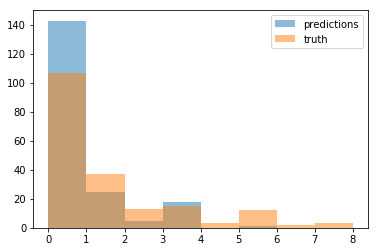

In [20]:
bins = np.arange(9)
plt.hist(np.array(trainer.collect_preds), bins, alpha=0.5, label='predictions')
plt.hist(np.array(trainer.collect_truth), bins, alpha=0.5, label='truth')
plt.legend(loc='upper right')  

In [21]:
np.histogram(trainer.collect_truth, bins=8)

(array([107,  37,  13,  15,   3,  12,   2,   3]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]))

# step5: visualizing the hidden to output weight matrix

In [22]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

ImportError: No module named 'bokeh'

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
plot_W2 = tsne.fit_transform(trainer.W2.T)

In [ ]:
label_lookup

In [ ]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=plot_W2[:,0],
                                    x2=plot_W2[:,1],
                                    names=label_lookup))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)